# Drone simulator
The purpose of this simulator is the take real-world aerial survey data, compute population density based on a distance-sampling approach and use it as input for a simulated survey. In this example, we will be using data collected by helicopter of moose in the Alberta.
In the first part, we will be:
- load the real-world data
- compute detection courve
- compute population density
Part two, will:
- define drone parameters for survey
- generate flight lines
- simulate detection

The next interation will include canopy cover as a variable

In [58]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, LineString
from scipy.optimize import curve_fit
from scipy.stats import norm
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt

## Part 1: Estimating Population Density and Abundance

Load shapefiles

In [43]:
area = gpd.read_file("D:/WMU/base_data/WMU/wmu_501_3400.shp")
transects = gpd.read_file("D:/WMU/survey_data/WMU 501 (2018-2019)/WMU501_transects_2018.gpx", layer='tracks')
moose = gpd.read_file("D:/WMU/survey_data/501_moose_locations.shp")
area = area.to_crs(epsg=3400)
transects = transects.to_crs(epsg=3400)
moose = moose.to_crs(epsg=3400)

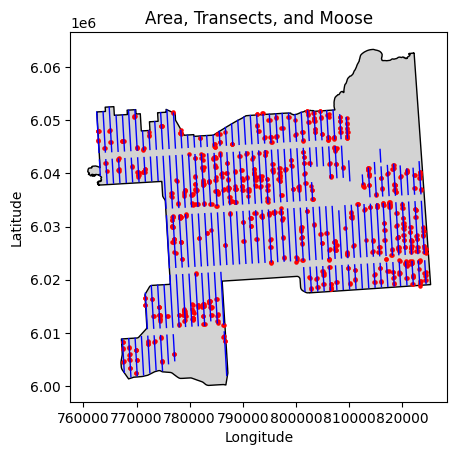

In [46]:
# Create a single plot with area, transects, and moose overlaying each other
fig, ax = plt.subplots()

# Plot the area
area.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the transects
transects.plot(ax=ax, color='blue', linewidth=1)

# Plot the moose
moose.plot(ax=ax, color='red', markersize=5)

# Set the plot title and labels
ax.set_title('Area, Transects, and Moose')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

Calculate distance from each moose sighting to the nearest transect

In [45]:
moose['distance_to_transect'] = moose.geometry.apply(
    lambda x: transects.distance(x).min()
)

0       24.433297
1      145.561005
2      103.989174
3       90.625758
4       47.219447
          ...    
959    122.604042
960    146.924625
961     51.977631
962     65.251818
963     64.955529
Name: distance_to_transect, Length: 964, dtype: float64


Fit detection function using distance sampling data

In [60]:
def detection_function(distance, a, b):
    return a * np.exp(-b * distance)

distances = moose['distance_to_transect'].values
detected = np.ones_like(distances)  # Assuming all observed moose were detected
params, _ = curve_fit(detection_function, distances, detected)

C:\Users\lhambrec\AppData\Local\Temp\ipykernel_12668\4269213095.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * distance)


In [72]:
params[1]

np.float64(-3.6392021391396554e-12)

Plot detection funciton

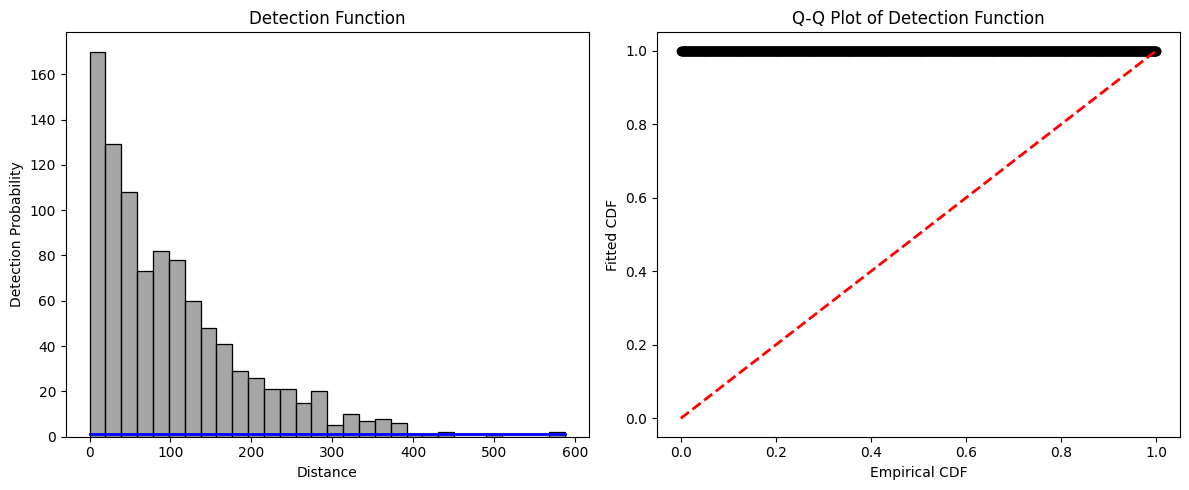

In [73]:

# Example parameters from curve fitting (replace with actual fitted params)
a = params[0]
b = params[1]
predicted_probabilities = detection_function(distances, a, b)

# Plotting the histogram with the fitted detection function
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(distances, bins=30, kde=False, color='gray', edgecolor='black', alpha=0.7)
distance_bins = np.linspace(0, max(distances), 100)
fitted_curve = detection_function(distance_bins, a, b)
plt.plot(distance_bins, fitted_curve, color='blue', lw=2)
plt.xlabel('Distance')
plt.ylabel('Detection Probability')
plt.title('Detection Function')

# Q-Q Plot or fitted vs. empirical CDF
plt.subplot(1, 2, 2)
# Simulating empirical CDF (in actual use, calculate from data)
empirical_cdf = np.cumsum(np.ones_like(distances)) / len(distances)
sorted_distances = np.sort(distances)
fitted_cdf = detection_function(sorted_distances, a, b)
plt.plot(empirical_cdf, fitted_cdf, 'o', color='black')
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel('Empirical CDF')
plt.ylabel('Fitted CDF')
plt.title('Q-Q Plot of Detection Function')

plt.tight_layout()
plt.show()

Estimate density and abundance

In [55]:
area_size = area.geometry.area.sum()  # in square km
density = detected.sum() / (area_size * params[0])
abundance = density * area_size

Rasterize the density and abundance

In [49]:
def create_raster(geometry, values, transform, width, height):
    shapes = ((geom, value) for geom, value in zip(geometry, values))
    return rasterize(shapes, out_shape=(height, width), transform=transform)

Set up the raster transform (example values, adjust as necessary)

In [50]:
transform = rasterio.transform.from_bounds(*area.total_bounds, 100, 100)
width, height = 100, 100

Create the raster

In [51]:
density_raster = create_raster(area.geometry, [density] * len(area), transform, width, height)

Plot raster

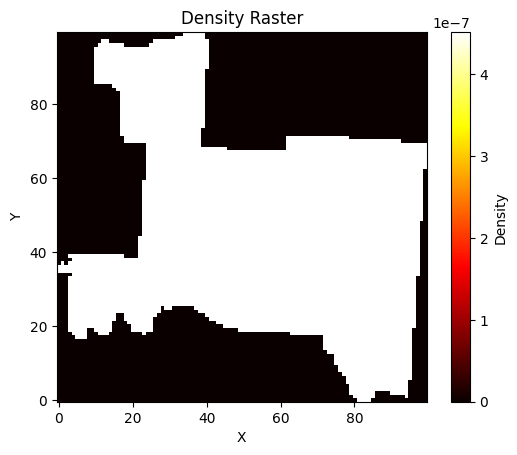

In [52]:
plt.imshow(density_raster, cmap='hot', origin='lower')
plt.colorbar(label='Density')
plt.title('Density Raster')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Part 2: Simulating a Drone Survey

Define drone parameters

In [34]:
field_of_view = 60  # degrees
altitude = 100  # meters
camera_width = 2 * altitude * np.tan(np.radians(field_of_view / 2))

Generate flight lines
(Assume simple grid pattern, this should be refined for actual use)

In [35]:
minx, miny, maxx, maxy = area.total_bounds
x_coords = np.arange(minx, maxx, camera_width)
y_coords = np.arange(miny, maxy, camera_width / 2)
flight_lines = [LineString([(x, miny), (x, maxy)]) for x in x_coords]

Simulate detections
(Simple model: all moose within the camera width are detected)

In [38]:
def simulate_detections(moose, flight_lines, camera_width):
    detected_moose = []
    for line in flight_lines:
        buffer = line.buffer(camera_width / 2)
        detections = moose[moose.intersects(buffer)]
        detected_moose.append(detections)
    return pd.concat(detected_moose)

simulated_detections = simulate_detections(moose, flight_lines, camera_width)

Plot raster

TypeError: Image data of dtype object cannot be converted to float

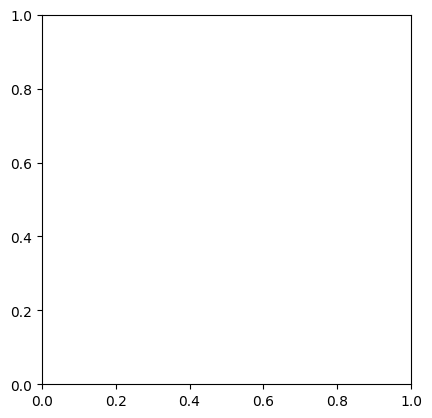

In [39]:
plt.imshow(simulated_detections, cmap='hot', origin='lower')
plt.colorbar(label='Density')
plt.title('Density Raster')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Save results (raster, detected moose)

In [40]:
with rasterio.open('density_raster.tif', 'w', driver='GTiff',
                   height=density_raster.shape[0], width=density_raster.shape[1],
                   count=1, dtype=density_raster.dtype,
                   crs=area.crs, transform=transform) as dst:
    dst.write(density_raster, 1)

simulated_detections.to_file("simulated_detections.shp")

print(f"Estimated Density: {density} moose/sq km")
print(f"Estimated Abundance: {abundance} moose")

Estimated Density: 4.515767400051595e-07 moose/sq km
Estimated Abundance: 964.0 moose


C:\Users\lhambrec\AppData\Local\Temp\ipykernel_12668\1291727568.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  simulated_detections.to_file("simulated_detections.shp")
c:\Users\lhambrec\Sync\1_Projects\Simulator\DroneSurveySimulator\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(
c:\Users\lhambrec\Sync\1_Projects\Simulator\DroneSurveySimulator\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distance_to_transect' to 'distance_t'
  ogr_write(
